## Notebook to track UKBB subjects with two visits

### Last basket update (Dec 2022)

### Derivative proc status 
- Based on `fmriprep_validator.py` and `fs_validator.py`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Paths


In [2]:
project_dir = "../"
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

# Manifest (i.e. available subjects with ses-3 imaging data)
ukbb_manifest = f"{data_dir}/subject_ids/ukbb_participant_ids_Nov2022.txt"

ukbb_bids_participants_tsv = f"{data_dir}/subject_ids/participants.tsv"
ukbb_bids_session_participants_csv = f"{data_dir}/subject_ids/ukb_bids_status.csv"

# Tabular data (i.e. demographics)
ukbb_tab_version = "ukb670039" #"ukb670039" (Dec 2022) #older version: "ukb49190.csv" (April 2022)
ukbb_tab_csv = f"{data_dir}tabular/{ukbb_tab_version}.csv" 
ukbb_demograph_csv = f"{data_dir}tabular/{ukbb_tab_version}_demographics.csv" 
ukbb_ses2and3_demograph_csv = f"{data_dir}tabular/{ukbb_tab_version}_ses2and3_demographics.csv" 

# Processed derivatives (i.e. fmriprep based spatial normalization and FreeSurfer DKT values)
ukbb_proc_status_dir = f"{data_dir}proc_status/"
ukbb_freesurfer_agg_dir = f"{data_dir}derivatives/freesurfer-agg/"

# Experiment setup (i.e. train, test, val subsets)
exp_setup_dir = f"{data_dir}exp_setup/"

## Total available subjects

In [3]:
manifest_participant_ids = list(np.squeeze(pd.read_csv(ukbb_manifest).values))
print(f"Number of available participants: {len(manifest_participant_ids)}")

bids_participant_ids = list(np.squeeze(pd.read_csv(ukbb_bids_participants_tsv, sep="/t")["participant_id"].values))
print(f"Number of BIDS participants: {len(bids_participant_ids)}")

bids_ses_status_df = pd.read_csv(ukbb_bids_session_participants_csv)
ses2_bids_participants = bids_ses_status_df[bids_ses_status_df["ses-2"]==1]["participant_id"].unique()
ses3_bids_participants = bids_ses_status_df[bids_ses_status_df["ses-3"]==1]["participant_id"].unique()
n_ses2_bids_participants = len(ses2_bids_participants)
n_ses3_bids_participants = len(ses3_bids_participants)

print(f"number of BIDS ses-2 participants: {n_ses2_bids_participants}")
print(f"number of BIDS ses-3 participants: {n_ses3_bids_participants}")
bids_ses_status_df.head()

Number of available participants: 4588
Number of BIDS participants: 4700
number of BIDS ses-2 participants: 4446
number of BIDS ses-3 participants: 4589


,participant_id,ses-2,ses-3
0,sub-4260378,1,1
1,sub-4847795,1,1
2,sub-2393732,1,1
3,sub-3618956,1,1
4,sub-5770965,1,1


## Select few columns (cannot read entire CSV in memory)

In [4]:
read_neurohub_manifest = False
save_ukbb_demograph = True
select_subjects_with_followup = True
save_ukbb_followup_subset = True

if read_neurohub_manifest:
    column_codes = {
        "eid":"eid", 
        "31-0.0":"sex",
        "34-0.0":"birth_year",
        "21022-0.0": "age_at_recruitment",
        "21003-2.0": "age_at_ses2",
        "21003-3.0": "age_at_ses3",
        "21000-0.0":"ethnicity", 
        "20252-2.0":"T1-ses2",
        "20252-3.0":"T1-ses3",
        "53-2.0":"imaging date-ses2",
        "53-3.0":"imaging date-ses3"}

    ukbb_demograph_df = pd.read_csv(ukbb_tab_csv, index_col=["eid"], usecols=column_codes.keys())

    ukbb_demograph_df = ukbb_demograph_df.rename(columns=column_codes)

    if save_ukbb_demograph:
        ukbb_demograph_df.to_csv(ukbb_demograph_csv)


    if select_subjects_with_followup:
        # Make sure subjects have imaging data from ses2 and ses3
        ukbb_demograph_df = ukbb_demograph_df[(~ukbb_demograph_df["T1-ses2"].isna()) & (~ukbb_demograph_df["T1-ses3"].isna())]

        print(f'Number of available follow up subjects: {len(ukbb_demograph_df)}')

    ## Save ukbb follow-up data csv to save time reading entire tabular data csv 
    if save_ukbb_followup_subset: 
        ukbb_demograph_df.to_csv(ukbb_ses2and3_demograph_csv)

else:
    ukbb_demograph_df = pd.read_csv(ukbb_demograph_csv)
    ukbb_ses2and3_demograph_df = pd.read_csv(ukbb_ses2and3_demograph_csv)


print(f"shape of ukbb_ses2and3_demograph: {ukbb_demograph_df.shape}")
ukbb_demograph_df.head()


shape of ukbb_ses2and3_demograph: (502394, 11)


,eid,sex,birth_year,imaging date-ses2,imaging date-ses3,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment
0,1000011,0,1955.0,2019-10-19,2021-05-27,20252_2_0,20252_3_0,1001.0,64.0,65.0,52.0
1,1000026,0,1947.0,NaN,NaN,NaN,NaN,1001.0,NaN,NaN,60.0
2,1000032,0,1967.0,NaN,NaN,NaN,NaN,1001.0,NaN,NaN,42.0
3,1000044,1,1946.0,NaN,NaN,NaN,NaN,1001.0,NaN,NaN,61.0
4,1000058,0,1948.0,NaN,NaN,NaN,NaN,1001.0,NaN,NaN,60.0


### Slice based on available BIDS subjects:


In [5]:
bids_participants_two_visits = set(ses2_bids_participants) & set(ses3_bids_participants)
print(f"Number of BIDS participants with two visits: {len(bids_participants_two_visits)}")

bids_eid_list = [int(s.split("-",2)[1]) for s in bids_participants_two_visits]

ukbb_demograph_df = ukbb_demograph_df[ukbb_demograph_df["eid"].isin(bids_eid_list)]

ukbb_demograph_df.head()

Number of BIDS participants with two visits: 4335


,eid,sex,birth_year,imaging date-ses2,imaging date-ses3,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment
62,1000635,1,1950.0,2017-12-21,2020-03-09,20252_2_0,20252_3_0,1001.0,67.0,69.0,58.0
406,1004084,1,1947.0,2017-05-23,2019-10-23,20252_2_0,20252_3_0,1001.0,70.0,72.0,60.0
837,1008391,1,1955.0,2017-10-13,2021-02-17,20252_2_0,20252_3_0,1001.0,62.0,65.0,54.0
964,1009663,1,1957.0,2019-01-25,2021-09-02,20252_2_0,20252_3_0,1001.0,61.0,64.0,51.0
1004,1010063,0,1964.0,2017-07-05,2019-10-29,20252_2_0,20252_3_0,1001.0,53.0,55.0,45.0


### Distribution of visit intervals

In [6]:
ukbb_demograph_df["age_at_ses2"] = ukbb_demograph_df["age_at_ses2"].astype(int)
ukbb_demograph_df["age_at_ses3"] = ukbb_demograph_df["age_at_ses3"].astype(int)
ukbb_demograph_df["visit_interval"] = ukbb_demograph_df["age_at_ses3"] - ukbb_demograph_df["age_at_ses2"]
ukbb_demograph_df["imaging date-ses2"] = pd.to_datetime(ukbb_demograph_df["imaging date-ses2"])
ukbb_demograph_df["imaging date-ses3"] = pd.to_datetime(ukbb_demograph_df["imaging date-ses3"])

ukbb_demograph_df["visit_interval_months"] = (ukbb_demograph_df["imaging date-ses3"] - 
                                                ukbb_demograph_df["imaging date-ses2"])/np.timedelta64(1, 'M')
ukbb_demograph_df["visit_interval_months"] = ukbb_demograph_df["visit_interval_months"].astype(int)
ukbb_demograph_df["visit_interval"].value_counts()

2    2587
3    1171
5     171
6     152
4     133
7      61
1      57
8       2
Name: visit_interval, dtype: int64

## plots

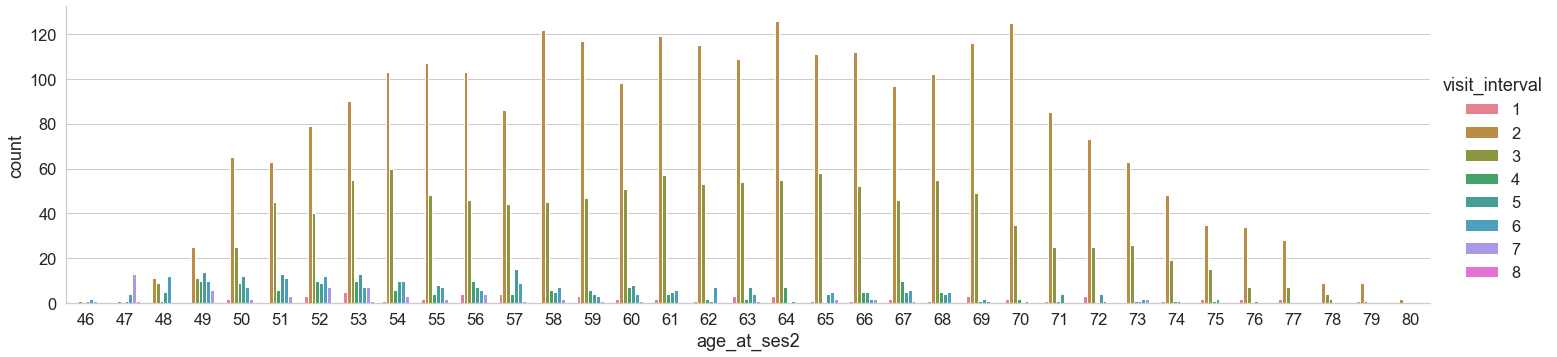

In [7]:
plot_df = ukbb_demograph_df.copy()
palette = 'husl'
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="age_at_ses2", hue="visit_interval", kind='count',
    aspect=4, height=5, palette = palette, data=plot_df)


## Check derivative proc status

In [8]:
proc_subset_list = ["fmriprep"]
ses_list = ["ses-2","ses-3"]
modality = "anat"

fmristatus_df = pd.DataFrame()
for proc_subset in proc_subset_list:    
    for ses in ses_list:
        fmristatus_csv = f"{ukbb_proc_status_dir}/{proc_subset}/{ses}/fmriprep_status.csv"

        df = pd.read_csv(fmristatus_csv)

        n_MNI152NLin2009cSym = len(df[df[f"{modality}-MNI152NLin2009cSym_res-1"]=="Pass"])
        n_MNI152NLin6Sym = len(df[df[f"{modality}-MNI152NLin6Sym_res-1"]=="Pass"])
        n_MNI152Lin = len(df[df[f"{modality}-MNI152Lin_res-1"]=="Pass"])
        n_fsl_MNI152NLin6Sym = len(df[df[f"fsl-MNI152NLin6Sym"]=="Pass"])
        
        df["session"] = ses
        df["proc_subset"] = proc_subset
        fmristatus_df = fmristatus_df.append(df)

        print(f"proc_subset: {proc_subset}, session: {ses}")
        print(f"n_MNI152NLin2009cSym: {n_MNI152NLin2009cSym}, n_MNI152NLin6Sym: {n_MNI152NLin6Sym} "
        f"n_MNI152Lin: {n_MNI152Lin}, n_fsl_MNI152NLin6Sym:{n_fsl_MNI152NLin6Sym}")
        print("")

n_participants_ses2 = len(fmristatus_df[fmristatus_df["session"]=="ses-2"])
n_participants_ses3 = len(fmristatus_df[fmristatus_df["session"]=="ses-3"])

print(f"n_ses-2: {n_participants_ses2}, n_ses-3: {n_participants_ses3}")

fmristatus_df.head()

proc_subset: fmriprep, session: ses-2
n_MNI152NLin2009cSym: 1493, n_MNI152NLin6Sym: 4441 n_MNI152Lin: 1493, n_fsl_MNI152NLin6Sym:0

proc_subset: fmriprep, session: ses-3
n_MNI152NLin2009cSym: 1530, n_MNI152NLin6Sym: 4588 n_MNI152Lin: 4588, n_fsl_MNI152NLin6Sym:0

n_ses-2: 4700, n_ses-3: 4700


,Unnamed: 0,participant_id,anat-fmriprep_complete,anat-MNI152NLin2009cSym_res-1,anat-MNI152NLin6Sym_res-1,anat-MNI152Lin_res-1,fsl-MNI152NLin6Sym,fmriprep_complete,session,proc_subset
0,0,sub-4853651,False,space-MNI152NLin2009cSym_res-1_desc-brain_mask...,Pass,space-MNI152Lin_res-1_desc-brain_mask.json not...,space-MNI152NLin6Sym_desc-PMF6_T1w.nii.gz not ...,False,ses-2,fmriprep
1,1,sub-5306066,False,space-MNI152NLin2009cSym_res-1_desc-brain_mask...,Pass,space-MNI152Lin_res-1_desc-brain_mask.json not...,space-MNI152NLin6Sym_desc-PMF6_T1w.nii.gz not ...,False,ses-2,fmriprep
2,2,sub-4706191,True,Pass,Pass,Pass,space-MNI152NLin6Sym_desc-PMF6_T1w.nii.gz not ...,True,ses-2,fmriprep
3,3,sub-2535410,False,space-MNI152NLin2009cSym_res-1_desc-brain_mask...,Pass,space-MNI152Lin_res-1_desc-brain_mask.json not...,space-MNI152NLin6Sym_desc-PMF6_T1w.nii.gz not ...,False,ses-2,fmriprep
4,4,sub-4776512,False,space-MNI152NLin2009cSym_res-1_desc-brain_mask...,Pass,space-MNI152Lin_res-1_desc-brain_mask.json not...,space-MNI152NLin6Sym_desc-PMF6_T1w.nii.gz not ...,False,ses-2,fmriprep


## Check freesurfer DKT status

In [9]:
proc_subset_list = ["pre_ohbm","post_ohbm","nov_2022"]
ses_list = ["ses-2","ses-3"]

DKT_status_df = pd.DataFrame()
for proc_subset in proc_subset_list:    
    for ses in ses_list:
        if (proc_subset == "post_ohbm") & (ses == "ses-3"): 
            ses3_batch_list = ["ohbm_train_subjects_1-800","ohbm_train_subjects_801-1749"]
            for ses3_batch in ses3_batch_list:
                DKT_csv = f"{ukbb_freesurfer_agg_dir}/{proc_subset}/{ses}/{ses3_batch}/DKTatlas_average_thickness.csv"
                df = pd.read_csv(DKT_csv)
                df["session"] = ses
                df["proc_subset"] = proc_subset
                DKT_status_df = DKT_status_df.append(df)
        else:
            DKT_csv = f"{ukbb_freesurfer_agg_dir}/{proc_subset}/{ses}/DKTatlas_average_thickness.csv"
            df = pd.read_csv(DKT_csv)
            df["session"] = ses
            df["proc_subset"] = proc_subset
            DKT_status_df = DKT_status_df.append(df)


n_participants_ses2 = len(DKT_status_df[DKT_status_df["session"]=="ses-2"])
n_participants_ses3 = len(DKT_status_df[DKT_status_df["session"]=="ses-3"])

print(f"n_ses-2: {n_participants_ses2}, n_ses-3: {n_participants_ses3}")

DKT_status_df.head()

n_ses-2: 4423, n_ses-3: 4589


,Unnamed: 0,subject_id,27174,27175,27176,27177,27178,27179,27180,27181,...,27290,27291,27292,27293,27294,27295,27296,27297,session,proc_subset
0,0,sub-3239964,2.491,2.519,1.799,3.039,2.565,2.313,2.679,2.250,...,2.657,2.192,2.409,1.997,2.670,2.302,1.991,2.842,ses-2,pre_ohbm
1,1,sub-1247311,2.985,2.481,1.881,3.213,2.666,2.557,2.892,2.663,...,2.797,2.326,2.585,2.190,2.830,2.583,2.665,2.835,ses-2,pre_ohbm
2,2,sub-2970850,2.672,2.640,2.025,3.262,2.663,2.376,2.751,2.282,...,2.611,2.214,2.519,2.068,2.528,2.316,2.355,2.949,ses-2,pre_ohbm
3,3,sub-3102962,2.787,2.667,2.044,3.540,2.746,2.445,3.066,2.259,...,2.971,2.342,2.760,2.266,2.962,2.618,2.550,2.897,ses-2,pre_ohbm
4,4,sub-5092623,2.635,2.527,2.092,3.138,2.840,2.496,2.979,2.920,...,2.675,2.318,2.608,2.297,2.922,2.692,2.716,3.029,ses-2,pre_ohbm


## Subjects need to be (re-)processed

In [10]:
fmriprep_success_ses2 = fmristatus_df[(fmristatus_df["anat-MNI152NLin6Sym_res-1"]=="Pass") & (fmristatus_df["session"]=="ses-2")]["participant_id"]
fmriprep_success_ses3 = fmristatus_df[(fmristatus_df["anat-MNI152NLin6Sym_res-1"]=="Pass") & (fmristatus_df["session"]=="ses-3")]["participant_id"]

freesurfer_success_ses2 = DKT_status_df[DKT_status_df["session"]=="ses-2"]["subject_id"]
freesurfer_success_ses3 = DKT_status_df[DKT_status_df["session"]=="ses-3"]["subject_id"]

print(f"bids participants, ses-2: {n_ses2_bids_participants}, ses-3: {n_ses3_bids_participants}")
print(f"n_fmriprep success, ses-2: {len(fmriprep_success_ses2)}, ses-3: {len(fmriprep_success_ses3)}")
print(f"n_freesurfer success, ses-2: {len(freesurfer_success_ses2)}, ses-3: {len(freesurfer_success_ses3)}")

fmriprep_reprocesses_ses2 = set(ses2_bids_participants) - set(fmriprep_success_ses2)
fmriprep_reprocesses_ses3 = set(ses3_bids_participants) - set(fmriprep_success_ses3)
freesurfer_reprocess_ses2 = set(ses2_bids_participants) - set(freesurfer_success_ses2)
freesurfer_reprocess_ses3 = set(ses3_bids_participants) - set(freesurfer_success_ses3)

print(f"n_reprocess, fmriprep_ses2: {len(fmriprep_reprocesses_ses2)}, fmriprep_ses3: {len(fmriprep_reprocesses_ses3)}\n \
           freesufer_ses2: {len(freesurfer_reprocess_ses2)}, freesufer_ses3: {len(freesurfer_reprocess_ses3)}")

reprocess_ses2_ids = fmriprep_reprocesses_ses2.union(freesurfer_reprocess_ses2)
reprocess_ses3_ids = fmriprep_reprocesses_ses3.union(freesurfer_reprocess_ses3)

print(f"n_reprocess ids, ses-2: {len(reprocess_ses2_ids)}, ses-3: {len(reprocess_ses3_ids)}")

bids participants, ses-2: 4446, ses-3: 4589
n_fmriprep success, ses-2: 4441, ses-3: 4588
n_freesurfer success, ses-2: 4423, ses-3: 4589
n_reprocess, fmriprep_ses2: 5, fmriprep_ses3: 1
            freesufer_ses2: 24, freesufer_ses3: 1
n_reprocess ids, ses-2: 25, ses-3: 1


### Save reprocess participant_ids lists

In [11]:
save_reproce_ids = False

if save_reproce_ids:
    save_df = pd.DataFrame()
    save_df["participant_id"] = list(reprocess_ses2_ids)
    save_df.to_csv(f"{data_dir}/subject_ids/ukbb_reprocess_ids_ses2.txt",index=None,header=None)

    save_df = pd.DataFrame()
    save_df["participant_id"] = list(reprocess_ses3_ids)
    save_df.to_csv(f"{data_dir}/subject_ids/ukbb_reprocess_ids_ses3.txt",index=None,header=None)

## Train - Val - Test splits

- Stratifying based on sex and visit_interval (age get stratfied automatically with large N)
- Doing only one split (relatively large N and deep-learning models)
- Visit_interval <= 3 years in the train set
- Doing multiple validation and test sets
    - Stratified train, val and test sets of subjects for visit_interval <=3 years
    - Additional val and test sets for visit_interval >3 years 


In [12]:
freesurfer_success_ids =  set(freesurfer_success_ses2) & set(freesurfer_success_ses3)
fmriprep_success_ids = set(fmriprep_success_ses2) & set(fmriprep_success_ses3)

proc_success_ids = freesurfer_success_ids & fmriprep_success_ids

print(f"number of proc success ids: \n \
    freesurfer: {len(freesurfer_success_ids)}, \
    fmriprep: {len(fmriprep_success_ids)}, \
    total: {len(proc_success_ids)}")

number of proc success ids: 
     freesurfer: 4310,     fmriprep: 4330,     total: 4310


### Split shorter visit_interval samples into "train","val","test"

In [13]:
RANDOM_STATE = 153
strata_cols = ["sex","visit_interval"]

exp_eid_list = [int(s.split("-",2)[1]) for s in proc_success_ids]
experiment_df = ukbb_demograph_df[ukbb_demograph_df["eid"].isin(exp_eid_list)].copy()

# Train only with shorter visit interval (we will still use val and test set here)
experiment_short_term_df = experiment_df[experiment_df["visit_interval"] <= 3]
# Additional val and test set with longer visit intervals. 
experiment_long_term_df = experiment_df[experiment_df["visit_interval"] > 3]


print(f"n_experiment_df: {len(experiment_df)}   "
        f"n_experiment_short_term_df: {len(experiment_short_term_df)}   "
        f"experiment_long_term_df: {len(experiment_long_term_df)}")

# (Train-Val) - Test Split
train_val_df, test_df = train_test_split(experiment_short_term_df, 
                                    stratify=experiment_short_term_df[strata_cols], 
                                    random_state=RANDOM_STATE,
                                    test_size=0.1)
# Train - Val split
train_df, val_df = train_test_split(train_val_df, 
                                    stratify=train_val_df[strata_cols], 
                                    random_state=RANDOM_STATE,
                                    test_size=0.1)

print(f"n_train: {len(train_df)}, n_val: {len(val_df)}, n_test: {len(test_df)}")

# Sanity check
train_eids = train_df["eid"]
val_eids = val_df["eid"]
test_eids = test_df["eid"]

n_eid_overlap = len(set(train_eids) & set(val_eids) & set(test_eids))
n_total_eids = len(train_eids) + len(val_eids) + len(test_eids)

print(f"***Sanity Check***\nn_eid_overlap: {n_eid_overlap}, n_total_eids: {n_total_eids}")

experiment_short_term_df.loc[experiment_short_term_df["eid"].isin(train_eids),"CV_subset"] = "train"
experiment_short_term_df.loc[experiment_short_term_df["eid"].isin(val_eids),"CV_subset"] = "val"
experiment_short_term_df.loc[experiment_short_term_df["eid"].isin(test_eids),"CV_subset"] = "test"

experiment_short_term_df.head()

n_experiment_df: 4309   n_experiment_short_term_df: 3793   experiment_long_term_df: 516
n_train: 3071, n_val: 342, n_test: 380
***Sanity Check***
n_eid_overlap: 0, n_total_eids: 3793


,eid,sex,birth_year,imaging date-ses2,imaging date-ses3,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment,visit_interval,visit_interval_months,CV_subset
62,1000635,1,1950.0,2017-12-21,2020-03-09,20252_2_0,20252_3_0,1001.0,67,69,58.0,2,26,train
406,1004084,1,1947.0,2017-05-23,2019-10-23,20252_2_0,20252_3_0,1001.0,70,72,60.0,2,29,train
837,1008391,1,1955.0,2017-10-13,2021-02-17,20252_2_0,20252_3_0,1001.0,62,65,54.0,3,40,train
964,1009663,1,1957.0,2019-01-25,2021-09-02,20252_2_0,20252_3_0,1001.0,61,64,51.0,3,31,train
1004,1010063,0,1964.0,2017-07-05,2019-10-29,20252_2_0,20252_3_0,1001.0,53,55,45.0,2,27,val


### Generate demograph table 
- verify matching
- paper table

In [14]:
group_by_cols = ["CV_subset","sex"]
count_df = experiment_short_term_df.groupby(group_by_cols)["eid"].count().reset_index()
count_df = count_df.rename(columns={"eid":"N"})
age_mean_df = experiment_short_term_df.groupby(group_by_cols)["age_at_ses2"].mean().reset_index()
age_mean_df = age_mean_df.rename(columns={"age_at_ses2": "age_at_ses2 (mean)"})
age_std_df = experiment_short_term_df.groupby(group_by_cols)["age_at_ses2"].std().reset_index()
age_std_df = age_std_df.rename(columns={"age_at_ses2": "age_at_ses2 (std)"})

stat_df = pd.merge(count_df, age_mean_df, on=group_by_cols)
stat_df = pd.merge(stat_df, age_std_df, on=group_by_cols)

stat_df

,CV_subset,sex,N,age_at_ses2 (mean),age_at_ses2 (std)
0,test,0,203,60.773399,6.631599
1,test,1,177,63.378531,7.312675
2,train,0,1635,61.456881,7.066293
3,train,1,1436,62.845404,7.302221
4,val,0,182,62.653846,7.386411
5,val,1,160,62.787500,7.372725


### Split longer visit_interval samples into "val","test" (no train!)

In [15]:
# (Train-Val) - Test Split
longterm_val_df, longterm_test_df = train_test_split(experiment_long_term_df, 
                                    stratify=experiment_long_term_df[strata_cols], 
                                    random_state=RANDOM_STATE,
                                    test_size=0.5)

print(f"n_longterm_val_df: {len(longterm_val_df)}, n_longterm_test_df: {len(longterm_test_df)}")

longterm_val_eids = longterm_val_df["eid"]
longterm_test_eids = longterm_test_df["eid"]

experiment_long_term_df.loc[experiment_long_term_df["eid"].isin(longterm_val_eids),"CV_subset"] = "longterm_val"
experiment_long_term_df.loc[experiment_long_term_df["eid"].isin(longterm_test_eids),"CV_subset"] = "longterm_test"

experiment_long_term_df.head()

n_longterm_val_df: 258, n_longterm_test_df: 258


,eid,sex,birth_year,imaging date-ses2,imaging date-ses3,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment,visit_interval,visit_interval_months,CV_subset
4957,1049611,1,1965.0,2015-11-15,2021-08-08,20252_2_0,20252_3_0,1001.0,50,56,45.0,6,68,longterm_test
5370,1053758,0,1965.0,2014-12-01,2021-06-09,20252_2_0,20252_3_0,1001.0,49,56,43.0,7,78,longterm_val
5828,1058336,1,1961.0,2014-08-22,2021-03-04,20252_2_0,20252_3_0,1002.0,53,59,46.0,6,78,longterm_test
6615,1066205,0,1956.0,2015-06-05,2021-06-07,20252_2_0,20252_3_0,1001.0,58,64,51.0,6,72,longterm_val
7188,1071938,0,1966.0,2014-05-25,2021-03-14,20252_2_0,20252_3_0,1001.0,47,54,40.0,7,81,longterm_test


### Save experiment dfs

In [17]:
save_exp_setup = False
print(f"Saving exp setups here: {exp_setup_dir}")
if save_exp_setup:
    experiment_short_term_df.to_csv(f"{exp_setup_dir}ukbb_exp_setup_shortterm.csv",index=None)
    experiment_long_term_df.to_csv(f"{exp_setup_dir}ukbb_exp_setup_longterm.csv",index=None)


Saving exp setups here: /home/nikhil/projects/brain_changes/data/ukbb/exp_setup/
